In [1]:
%run 0-Base.py

In [2]:
NUM_MONTH_LAGS = 16
NUM_FEATURES   = 29

SOURCE_PATH = f'{DATA_PATH}/4-feature-engineered'
TARGET_PATH = f'{DATA_PATH}/5-scaled'

Read aggregated by *card_id* data of transactions:

In [3]:
%time aggregated_transactions_df = pd.read_feather(f'{SOURCE_PATH}/aggregated-transactions-by-card-id.feather')

with pd.option_context('display.max_columns', 1000): display(aggregated_transactions_df)

CPU times: user 433 ms, sys: 315 ms, total: 749 ms
Wall time: 213 ms


,card_id,month_lag,count,mean(authorized_flag),first(purchase_year),first(purchase_month),min(purchase_amount),mean(purchase_amount),max(purchase_amount),min(authorized_purchase_amount),mean(authorized_purchase_amount),max(authorized_purchase_amount),min(not_authorized_purchase_amount),mean(not_authorized_purchase_amount),max(not_authorized_purchase_amount),mean(installments_-1),mean(installments_0),mean(installments_1),mean(installments_2),mean(installments_3),mean(installments_4),mean(installments_5),mean(installments_6),mean(installments_7),mean(installments_8),mean(installments_9),mean(installments_10),mean(installments_11),mean(installments_12),mean(installments_999),season
0,C_ID_00007093c1,-12,4,1.000000,2017,2,-0.572600,-0.333604,0.037176,-0.572600,-0.333604,0.037176,NaN,NaN,NaN,0.000000,0.0,0.500000,0.250000,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,C_ID_00007093c1,-11,10,0.700000,2017,3,-0.677936,-0.571263,-0.401298,-0.677936,-0.560815,-0.401298,-0.671775,-0.595641,-0.557574,0.000000,0.0,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,C_ID_00007093c1,-10,12,0.750000,2017,4,-0.728876,-0.542391,0.004418,-0.728876,-0.546012,0.004418,-0.671775,-0.531528,-0.311139,0.000000,0.0,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,C_ID_00007093c1,-9,10,0.600000,2017,5,-0.698823,-0.342525,0.307953,-0.698823,-0.574854,-0.296112,-0.596447,0.005969,0.307953,0.000000,0.0,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,C_ID_00007093c1,-8,19,0.684211,2017,6,-0.728876,-0.519404,0.004418,-0.721363,-0.577617,-0.234504,-0.728876,-0.393276,0.004418,0.000000,0.0,0.684211,0.105263,0.210526,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3044123,C_ID_fffffd5772,-3,12,1.000000,2017,11,-0.728876,-0.694185,-0.518505,-0.728876,-0.694185,-0.518505,NaN,NaN,NaN,0.083333,0.0,0.916667,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3044124,C_ID_fffffd5772,-2,22,1.000000,2017,12,-0.731881,-0.694078,-0.535154,-0.731881,-0.694078,-0.535154,NaN,NaN,NaN,0.000000,0.0,0.909091,0.090909,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3044125,C_ID_fffffd5772,-1,10,0.900000,2018,1,-0.728876,-0.692835,-0.581616,-0.728876,-0.688830,-0.581616,-0.728876,-0.728876,-0.728876,0.000000,0.0,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3044126,C_ID_fffffd5772,0,24,0.666667,2018,2,-0.745405,-0.697689,-0.311139,-0.745405,-0.677963,-0.311139,-0.745405,-0.737141,-0.728876,0.000000,0.0,0.958333,0.000000,0.041667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def process_purchase_amounts(df):
    features = [
        'min(purchase_amount)',
        'mean(purchase_amount)',
        'max(purchase_amount)',

        'min(authorized_purchase_amount)',
        'mean(authorized_purchase_amount)',
        'max(authorized_purchase_amount)',

        'min(not_authorized_purchase_amount)',
        'mean(not_authorized_purchase_amount)',
        'max(not_authorized_purchase_amount)',
    ]

    X = df[features].values

    # get rid of negative values
    X += np.abs(np.nanmin(X, axis=0))
    X += 1e-8 # get rid of zeros
    X = np.log(X)

    X = StandardScaler().fit_transform(X)

    df[features] = X

def process_transactions_count(df):
    X = df[['count']].values

    X = np.log(X)

    X = StandardScaler().fit_transform(X)

    df[['count']] = X

def process_datetime(df):
    features = [
        'first(purchase_month)',
        'first(purchase_year)',
        'season',
    ]

    X = df[features].values

    X = MinMaxScaler().fit_transform(X)

    df[features] = X

%time process_datetime(aggregated_transactions_df)
%time process_purchase_amounts(aggregated_transactions_df)
%time process_transactions_count(aggregated_transactions_df)

CPU times: user 731 ms, sys: 108 ms, total: 839 ms
Wall time: 839 ms
CPU times: user 2.64 s, sys: 330 ms, total: 2.97 s
Wall time: 2.96 s
CPU times: user 509 ms, sys: 64.1 ms, total: 573 ms
Wall time: 572 ms


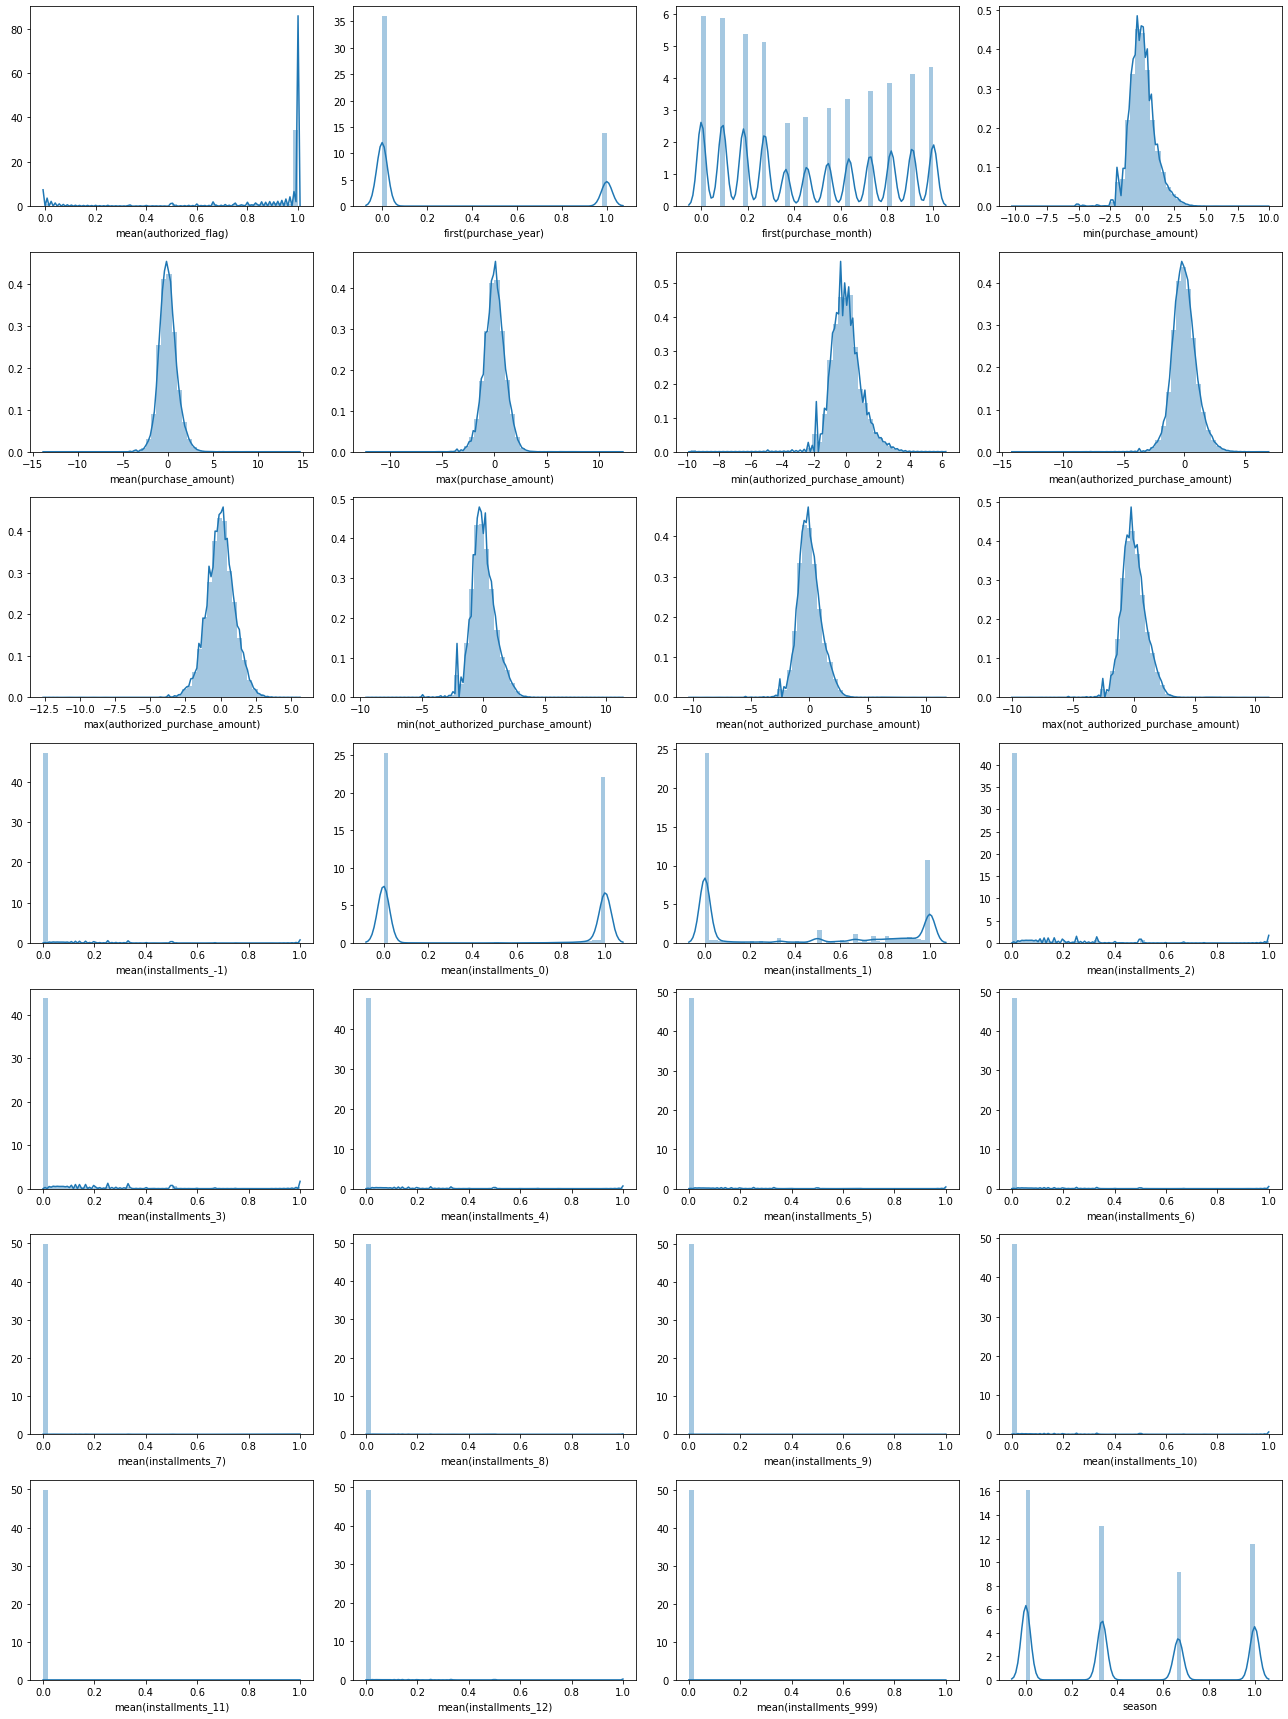

In [5]:
_, axs = plt.subplots(nrows=7, ncols=4, figsize=(18, 24))

for ax, feature in zip(axs.flat, aggregated_transactions_df.columns[3:]):
    sns.distplot(aggregated_transactions_df[feature].dropna(), ax=ax)

plt.tight_layout()

Read data about _train_ and _test_ customers:

In [6]:
train_df = pd.read_csv(f'{DATA_PATH}/raw/train.csv', usecols=['card_id', 'target'])
test_df  = pd.read_csv(f'{DATA_PATH}/raw/test.csv',  usecols=['card_id'])

%time customers_df = pd.concat([train_df, test_df], sort=False)

%time customers_df = customers_df.set_index('card_id')

display(customers_df)

CPU times: user 4.52 ms, sys: 38 µs, total: 4.56 ms
Wall time: 4.57 ms
CPU times: user 6.84 ms, sys: 3.63 ms, total: 10.5 ms
Wall time: 10.1 ms


,target
card_id,
C_ID_92a2005557,-0.820283
C_ID_3d0044924f,0.392913
C_ID_d639edf6cd,0.688056
C_ID_186d6a6901,0.142495
C_ID_cdbd2c0db2,-0.159749
...,...
C_ID_7a239d2eda,NaN
C_ID_75ace375ae,NaN
C_ID_21d56d950c,NaN


In [7]:
def process_customer_transactions_df(df):
    X = -999 * np.ones((NUM_MONTH_LAGS, NUM_FEATURES))
    X[df.month_lag] = df.values[:, 2:]
    X[np.isnan(X)] = -999
    return X

def process_transactions(df):
    df = df.copy()
    df.month_lag += 13 # solve the issue with negative month_lag while indexing

    X, y = [], []

    for card_id, customer_transactions_df in df.groupby('card_id'):
        X.append(process_customer_transactions_df(customer_transactions_df))
        y.append(customers_df.loc[card_id])

    X = np.concatenate(X).reshape(-1, NUM_MONTH_LAGS, NUM_FEATURES)
    y = np.concatenate(y).reshape(-1, 1)

    return X, y

%time X, y = process_transactions(aggregated_transactions_df)

display(X.shape, y.shape)

CPU times: user 2min 34s, sys: 1.68 s, total: 2min 36s
Wall time: 2min 36s


(325540, 16, 29)

(325540, 1)

In [8]:
train_ixs = np.isfinite(y).ravel()

X_train, X_test, y_train = X[train_ixs], X[~train_ixs], y[train_ixs]

In [9]:
np.save(f'{TARGET_PATH}/train/X.npy', X_train)
np.save(f'{TARGET_PATH}/train/y.npy', y_train)

np.save(f'{TARGET_PATH}/test/X.npy', X_test)